<a href="https://colab.research.google.com/github/sepehrilami/DataScienceInternship-AIMed/blob/master/PLS/PLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  Importing!

import torch
import torch.nn as nn
from torch.autograd import Variable

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
import nibabel as nib
from skimage.transform import resize

In [2]:
#Requird for reading mhd format
!pip install SimpleITK
import SimpleITK as sitk

     |████████████████████████████████| 44.9MB 68kB/s 


In [3]:
#Reading 3 samples from VESSEL12 dataset
!wget https://www.dropbox.com/sh/1j2x17k8y18k3l6/AACkAc6bCEqYVXBdODFo6Iqya/VESSEL12_ExampleScans.tar.bz2

--2020-10-27 07:26:56--  https://www.dropbox.com/sh/1j2x17k8y18k3l6/AACkAc6bCEqYVXBdODFo6Iqya/VESSEL12_ExampleScans.tar.bz2
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.1, 2620:100:601c:1::a27d:601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/1j2x17k8y18k3l6/AACkAc6bCEqYVXBdODFo6Iqya/VESSEL12_ExampleScans.tar.bz2 [following]
--2020-10-27 07:26:56--  https://www.dropbox.com/sh/raw/1j2x17k8y18k3l6/AACkAc6bCEqYVXBdODFo6Iqya/VESSEL12_ExampleScans.tar.bz2
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0fa29340f5192a2e3323f29505.dl.dropboxusercontent.com/cd/0/inline/BCCCz50zhXTPtKvQJYG4zPfujiDAml5-paBf7fqR5cwGEFsfHofuwcPHYpk8SVdSrnglOGglosubmD7kLidLZz4pHN_Av-7j2Rs05diJO9_jJg/file# [following]
--2020-10-27 07:26:57--  https://uc0fa29340f5192a2e3323f29505.dl.dropboxusercontent.com/cd/0/inline/BCC

In [4]:
#Unzip samples
!tar xf VESSEL12_ExampleScans.tar.bz2

In [5]:
def read_mhd(file):
    return sitk.GetArrayFromImage(sitk.ReadImage(file, sitk.sitkFloat32))

In [6]:
vessel12_21 = read_mhd("Scans/VESSEL12_21.mhd")
vessel12_21.shape

(459, 512, 512)

In [7]:
vessel12_21_mask = read_mhd("Lungmasks/VESSEL12_21.mhd")
vessel12_21_mask.shape

(459, 512, 512)

In [8]:
def draw(images, columns=4):
    rows = int(np.ceil(images.shape[0] / columns))
    max_size = 20
    
    width = max(columns * 5, max_size)
    height = width * rows // columns

    plt.figure(figsize=(width, height))
    plt.gray()
    plt.subplots_adjust(0,0,1,1,0.01,0.01)
    for i in range(images.shape[0]):
        plt.subplot(rows,columns,i+1), plt.imshow(images[i]), plt.axis('off')
        # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
    plt.show()

def draw_masked(images, masks, columns=4):
    assert images.shape == masks.shape
    
    rows = int(np.ceil(images.shape[0] / columns))
    max_size = 20
    
    width = min(columns * 5, max_size)
    height = width * rows // columns

    fig = plt.figure(figsize=(width, height))
    plt.gray()
    plt.subplots_adjust(0,0,1,1,0.01,0.01)
    
    X, Y = np.meshgrid(np.arange(masks.shape[1]), np.arange(masks.shape[2]))
    
    for i in range(images.shape[0]):
        ax = fig.add_subplot(rows,columns,i+1)
        if masks[i].sum() > 0:
            ax.contour(X, Y, masks[i], 1, colors='red', linewidths=0.5)
        ax.imshow(images[i], origin='lower', cmap='gray')
        plt.axis('off')
    
    plt.show()

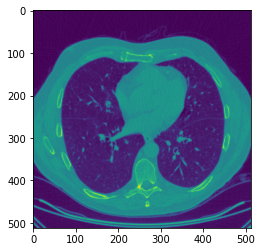

In [9]:
#As an example:
plt.imshow(vessel12_21[200])

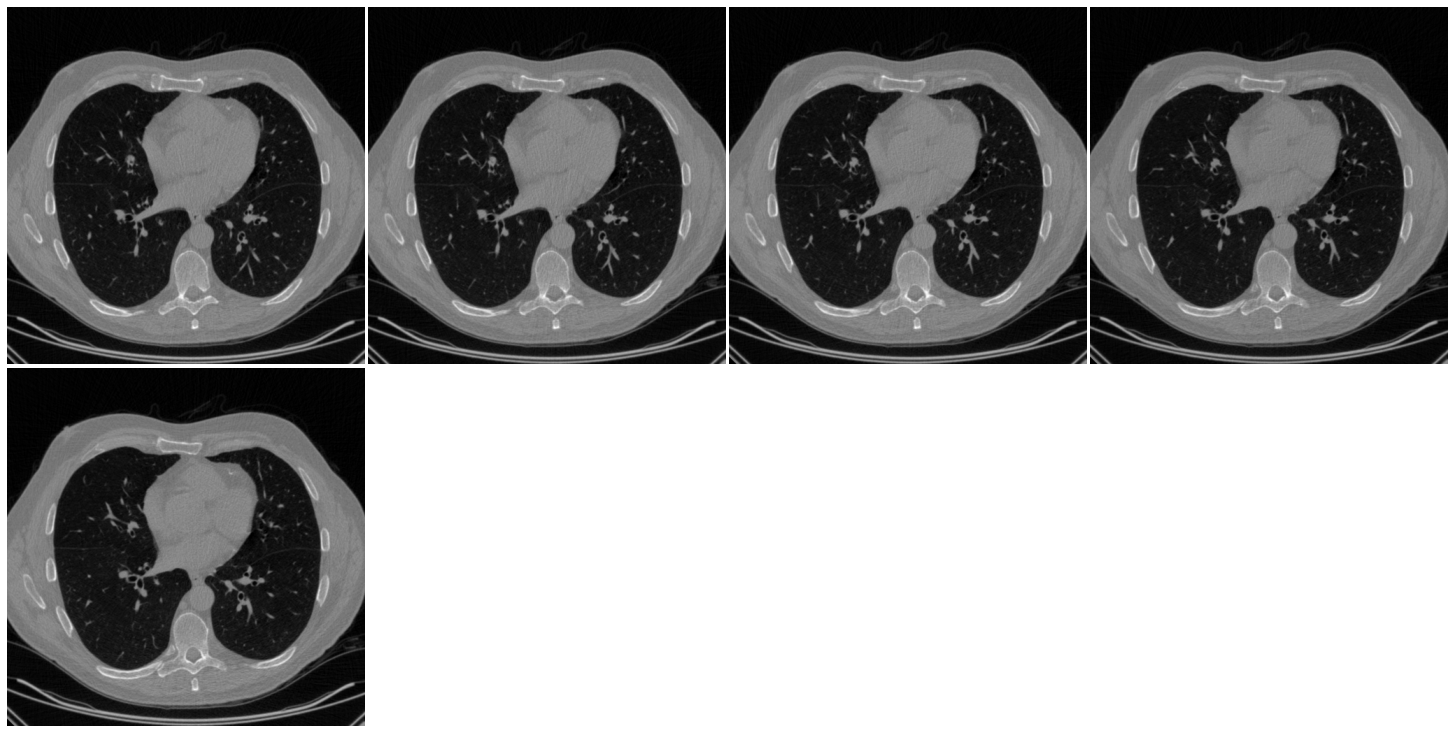

In [11]:
#It will take a few seconds
draw(vessel12_21[200:205])

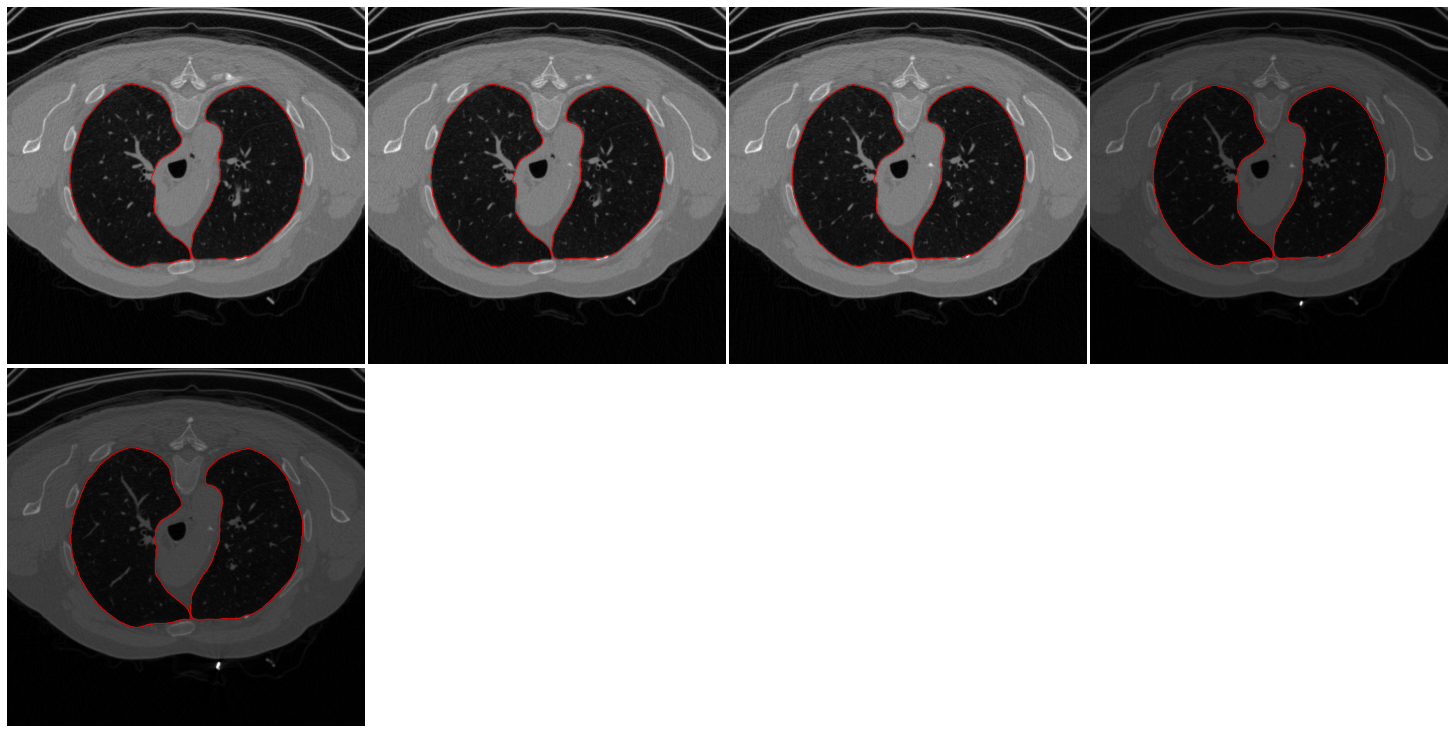

In [12]:
draw_masked(vessel12_21[300:305], vessel12_21_mask[300:305])

In [85]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.01)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.01)
        nn.init.constant_(m.bias.data, 0)

Defining Depthwise Separable (DS) Convolution And Dilated Residual Dense Block (DRDB)

# some note about variables names
DS prefix denotes Depthwise-Seperable's parameters.

DRDB prefix denotes DRDB's parameters.

In DRDB class, I used "in_channels" becouse in the DRDB block all the channel numbers are the same!

g0 is the last convolution in figure 3 that is a 1x1x1 convolution.

In [86]:
class DSconv(nn.Module):
  def __init__(self, in_channels, out_channels, DSkernel, DSstride, DSpadding):
    super(DSconv, self).__init__()

    self.dsconv = nn.Sequential(
        #Input is 10, 512, 512

        nn.Conv3d(10, in_channels, DSkernel, groups = in_channels),
        #here k is M * N or just M or 1 ?? 

        #K here is 1
        nn.Conv3d(in_channels, in_channels, DSkernel, DSstride, DSpadding, groups = in_channels),

        nn.BatchNorm3d(in_channels),
        nn.ReLU(inplace=True),
        nn.Conv3d(in_channels, out_channels, 1 ,DSstride, DSpadding),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, input, dilation = 1):
    print("dsconv shape of input:", input.shape)  
    return self.dsconv(input)


class DRDB(nn.Module):
      def __init__(self, in_channels, DRDBpadding, g, g0):
        super(DRDB, self).__init__()
        
        DSkernel = 3
        DSstride = 2
        DSpadding = DRDBpadding
        self.conv_1 = DSconv(in_channels, g, 3, 2, DRDBpadding)
        self.conv_2 = DSconv(in_channels, 2 * g, 3, 2, DRDBpadding)
        self.conv_3 = DSconv(in_channels, 3 * g, 3, 2, DRDBpadding)
        self.conv_4 = DSconv(in_channels, 4 * g, 3, 2, DRDBpadding)

        self.final_conv = nn.Conv3d(g0 + 4 * g, g0, 1, DSstride, DSpadding)

      def forward(self, DRDBinput):
        first_convolved = self.conv_1(DRDBinput)
        concat = torch.cat([first_convolved, DRDBinput], dim=1)
        second_convolved = self.conv_2(concat)
        concat = torch.cat([second_convolved, DRDBinput], dim=1)
        third_convolved = self.conv_3(concat)
        concat = torch.cat([third_convolved, DRDBinput], dim=1)
        forth_convolved = self.conv_4(concat)
        concat = torch.cat([forth_convolved, DRDRinput], dim=1)
        xg0 = self.final_conv(concat)
        
        return xg0 + DRDBinput


Model

In [87]:
class PLSnet(nn.Module):
  def __init__(self, in_channels, out_channels, DSkernel, DSstride, DSpadding, g, g0):
    super(PLSnet, self).__init__()

    self.dsconvolve = DSconv(in_channels, out_channels, DSkernel, DSstride, DSpadding)

    DRDBpadding = DSpadding
    self.drdb = DRDB(in_channels, DRDBpadding, g, 17)
    self.drdbx2 = DRDB(in_channels, DRDBpadding, g, 65)
    self.drdbx4 = DRDB(in_channels, DRDBpadding, g, 129)

    self.TLupsample = nn.Upsample(scale_factor=2, mode='trilinear')
    #self.TLdownsample = nn.functional.interpolate(input_image, scale_factor= 1/2, mode='trilinear') # for downscaling the input image in encoder
    self.oneconv = nn.Conv3d(in_channels, out_channels, 1 ,DSstride, DSpadding)
    self.softmaxAF = nn.Softmax()

  def forward(self, InputImage, real_mask):
    # resolution = 1 in encoder
    DSconv_1 = self.dsconvolve(InputImage)
    InputImage = nn.functional.interpolate(InputImage, scale_factor=1/2, mode='trilinear')
    concat_1 = torch.cat([DSconv_1,InputImage], dim=1)
    DRDB1_output = self.drdb(concat_1)
    # resolution = 2 in encoder
    DSconv_2 = self.dsconvolve(DRDB1_output)
    InputImage = nn.functional.interpolate(InputImage, scale_factor=1/2, mode='trilinear')
    concat_2 = torch.cat([DSconv_2,InputImage], dim=1)
    DRDB2_output = self.drdbx2(self.drdbx2(concat_2)) # Don't know, but the paper's architecture has a DRDBx2! and I don't know what's that mean!
    # resolution = 3 in encoder
    DSconv_3 = self.dsconvolve(DRDB2_output)

    InputImage = nn.functional.interpolate(InputImage, scale_factor = 1/2, mode = 'trilinear')
    concat_3 = torch.cat([DSconv_3,InputImage], dim=1)

    DRDB3_output = self.drdbx4(self.drdbx4(self.drdbx4(self.drdbx4(concat_3))))
    DSconv_4 = self.dsconvolve(DRDB3_output)
    upsample1_output = self.TLupsample(DSconv_4) # g3 that got upsample and is placed in decoder
    # resolution = 2 in decoder
    concat_4 = torch.cat([upsample1_output,DRDB2_output], dim = 1)
    DSconv_5 = self.dsconvolve(concat_4)
    upsample2_output = self.TLupsample(DSconv_5)
    # resolution = 1 in decoder
    concat_5 = torch.cat([upsample2_output,DRDB1_output], dim = 1)
    DSconv_6 = self.dsconvolve(concat_5)
    upsample3_output = self.TLupsample(DSconv_6)
    # resolution = 0 in decoder
    output = self.oneconv(upsample3_output)
    predicted = self.softmaxAF(output) 
    loss = -1 * torch.mean(predicts, real_mask)
    return predicted, loss

In [88]:
in_channels = 10
out_channels = 256
DSkernel = 3
DSstride = 1
DSpadding = 1
g = 12
g0 = 17

model = PLSnet(in_channels, out_channels, DSkernel, DSstride, DSpadding, g, g0)
model = model.cuda()

In [89]:

optimizer = torch.optim.Adam(filter(
    lambda p : p.requires_grad, model.parameters()),
    lr = 0.001
)

In [90]:
model.to(device = 'cuda:0')

PLSnet(
  (dsconvolve): DSconv(
    (dsconv): Sequential(
      (0): Conv3d(10, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), groups=10)
      (1): Conv3d(10, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=10)
      (2): BatchNorm3d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): Conv3d(10, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=(1, 1, 1))
      (5): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
    )
  )
  (drdb): DRDB(
    (conv_1): DSconv(
      (dsconv): Sequential(
        (0): Conv3d(10, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), groups=10)
        (1): Conv3d(10, 10, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), groups=10)
        (2): BatchNorm3d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (4): Conv3d(10, 12, kernel_size=(1, 1, 1), stride

In [91]:
batch_size = 64
batch_x_placeholder = torch.zeros(size= [batch_size, 10, 512, 512], dtype = torch.float32, device =torch.device('cuda:0'))
batch_y_placeholder = torch.zeros(size= [batch_size, 10, 512, 512], dtype = torch.long, device = torch.device('cuda:0'))

x_train = vessel12_21[200:210]
y_train = vessel12_21_mask[200:210]

epochs = 10

In [92]:
from time import time

In [93]:
iters_per_epoch = int(np.ceil(1.0 * len(x_train) / batch_size))

for e in range(epochs):
    t_start = time()

    model.train() # training phase

    # shuffling
    inds = np.arange(len(x_train))
    np.random.shuffle(inds)

    epoch_loss = 0
    true_positive = 0


    # iterating over the whole training set
    for iter in range(iters_per_epoch):

        batch_inds = inds[iter * batch_size: min(len(inds), (iter + 1) * batch_size)]

        print("batch_inds is: ", batch_inds)
        # reshaping placeholders
        if len(batch_inds) != len(batch_x_placeholder):
            batch_x_placeholder.resize_([len(batch_inds), 10, 512, 512])
            batch_y_placeholder.resize_([len(batch_inds), 10, 512, 512])

        print("HERE")
        print(y_train.shape)
        print(batch_y_placeholder.shape)
        batch_x_placeholder.copy_(torch.Tensor(x_train[batch_inds, np.newaxis, :, :]))
        batch_y_placeholder.copy_(torch.Tensor(y_train[batch_inds, np.newaxis, :, :]))

        b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)
        b_decision = b_decision.cpu().numpy()
      
        epoch_loss += float(b_loss) / iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
        true_positive += np.sum(y_train[batch_inds].astype(int) == b_decision)

        b_loss.backward() # calculates derivations

        optimizer.step()
        optimizer.zero_grad() # CARE: MUST DO

    epoch_train_accuracy = true_positive * 100.0 / len(x_train)
    train_loss[e] = epoch_loss
    train_acc[e] = epoch_train_accuracy
    
 # Validating over validation data
    with torch.no_grad():
        model.eval()  # validation phase

        val_inds = np.arange(len(x_val))

        val_iters_per_epoch = int(np.ceil(1.0 * len(x_val) / batch_size))

        epoch_validation_loss = 0
        val_true_positive = 0


        # iterating over the whole training set
        for iter in range(val_iters_per_epoch):

            val_batch_inds = val_inds[iter * batch_size: min(len(val_inds), (iter + 1) * batch_size)]

            # reshaping placeholders
            if len(batch_inds) != len(batch_x_placeholder):
                batch_x_placeholder.resize_([len(batch_inds), 10, 512, 512])
                batch_y_placeholder.resize_([len(batch_inds), 10, 512, 512])

            batch_x_placeholder.copy_(torch.Tensor(x_train[batch_inds, np.newaxis, :, :]))
            batch_y_placeholder.copy_(torch.Tensor(y_train[batch_inds, np.newaxis, :, :]))

            b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)
            b_decision = b_decision.cpu().numpy()
        
            epoch_validation_loss += float(b_loss) / val_iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
            val_true_positive += np.sum(y_val[val_batch_inds].astype(int) == b_decision)
                
        epoch_validation_accuracy = val_true_positive * 100.0 / len(x_val)
        val_loss[e] = epoch_validation_loss
        val_acc[e] = epoch_validation_accuracy
        # TO Complete
    
    print(f'Train epoch Loss: {epoch_loss:.4f}, train accuracy: {epoch_train_accuracy:.2f}, Validation Loss: {epoch_validation_loss:.4f}, validation accuracy: {epoch_validation_accuracy:.2f}')

    # Saving the model and optimizer state
    torch.save({
            'epoch': e,
            'optimizer_state_dict': optimizer.state_dict(),
            'model_state_dict': model.state_dict(),
            'train_loss': epoch_loss,
            'train_accuracy': epoch_train_accuracy,
            'validation_loss': epoch_validation_loss,
            'validation_accuracy': epoch_validation_accuracy
        }, 'epoch_%d_state.pt' % e)

    print('Epoch %d ended in %.2f secs.' % (e, time() - t_start,))


batch_inds is:  [5 9 6 8 0 4 7 2 3 1]
HERE
(10, 512, 512)
torch.Size([10, 10, 512, 512])
dsconv shape of input: torch.Size([10, 10, 512, 512])


RuntimeError: ignored